In [1]:
import dbconnect
import pandas as pd
import numpy as np

conn = dbconnect.connect("mgibson_dui")


Connected!



In [2]:
countyinfo = pd.read_sql_query("SELECT * FROM %s;" % "countyinfo", conn)
#commented out bc i don't want to keep pulling the dataframe from postgres

print("number of counties in MO: " + str(len(countyinfo)))
countyinfo.head()

number of counties in MO: 115


,index,fips,area_name,state,county_pop,undr19_percent,ovr64_percent,bachdegree_percent,traveltime_towork,household_income,blwpov_percent,retail_sales,landarea_sqmiles
0,1509,29001,Adair County,MO,25607,18.5,13.6,27.6,16.7,34733,23.7,310089,567.32
1,1510,29003,Andrew County,MO,17291,22.9,17.5,22.0,23.3,54336,8.2,79988,432.70
2,1511,29005,Atchison County,MO,5685,20.0,23.8,21.3,18.1,44426,11.6,86619,547.30
3,1512,29007,Audrain County,MO,25529,23.5,16.7,13.1,21.1,43013,17.0,247806,692.24
4,1513,29009,Barry County,MO,35597,23.0,20.2,13.3,22.4,38710,19.1,413782,778.25


In [3]:
# NHTSA FATAL accidents in Missouri in 2015: 

acc2015 = pd.read_sql_query("SELECT * FROM %s;" % "best_acc2015", conn)

#changes = ['youngdriver', 'drunk_dr', 'hitnrun', 'drowsy']

# we want to make 1: true, 0: false

#acc2015[changes] = acc2015[changes].replace(2, 0)

print("number of accidents: " + str(len(acc2015)))
acc2015.head()



number of accidents: 802


,index,st_case,fips,year,date,time,latitude,longitud,fatals,rur_urb,drunk_dr,ve_total,persons,peds,day_week,youngdriver,hitnrun,drowsy,weekday,daytime
0,16687,290003,29183,2015,2015-01-01,23:28,38.843944,-90.620472,2,1,1,1,2,0,5,1,0,0,1,0
1,16693,290009,29177,2015,2015-01-04,04:15,39.351778,-94.145222,1,1,0,1,1,0,1,1,0,0,0,0
2,16711,290027,29069,2015,2015-01-20,14:15,36.236361,-89.999861,1,1,0,1,2,0,3,0,0,1,1,1
3,16696,290012,29073,2015,2015-01-11,00:05,38.372167,-91.399778,1,1,1,1,1,0,1,1,0,0,0,0
4,16710,290026,29077,2015,2015-01-17,00:00,37.205208,-93.349347,1,0,0,1,1,1,7,1,0,0,0,0


In [6]:
# we want to know the aggregate number per county of the following:

sums = ['fatals', 'drunk_dr', 'youngdriver', 'hitnrun', 'persons', 'peds', 've_total', 'drowsy']


sumsbycounty = acc2015.groupby('fips', as_index=False)[sums].sum()
#print(fataldf[[0]])


# count the number of accidents in each county (ie number of rows in the accdata)
sumsbycounty['accidents'] = acc2015.groupby('fips', as_index=False)['index'].agg('count')['index']

sumsbycounty = countyinfo[['fips', 'county_pop', 'landarea_sqmiles']].merge(sumsbycounty, on='fips')


sumsbycounty.head()

numsbypop = sumsbycounty.copy()
numsbysqm = sumsbycounty.copy()
# making a new dataframe w raw numbers normalized by county population
for s in sums:
    numsbypop[s] = np.round(sumsbycounty[s] / sumsbycounty['county_pop'] * 100000, 2)

# and anothr one w raw numbers/ county landarea in sq miles
for s in sums:
    numsbysqm[s] = np.round(sumsbycounty[s] / sumsbycounty['landarea_sqmiles'] * 1000, 2)

print("Number of counties which had accidents in 2015: " + str(len(numsbypop))) 
#numsbysqm['fatals']

Number of counties which had accidents in 2015: 109


In [7]:
#len(countyinfo['fips'].loc[sumsbycounty['fips']])

#countyinfo[countyinfo['fips'].isin(sumsbycounty['fips'])]
#countyinfo.head()

# the problem is that theyre not the same datatype 
# problem resolved
# now we keep only the countyinfo for counties which had accidents
countyinfo = countyinfo[countyinfo['fips'].isin(sumsbycounty['fips'])]


countyinfo.head()

,index,fips,area_name,state,county_pop,undr19_percent,ovr64_percent,bachdegree_percent,traveltime_towork,household_income,blwpov_percent,retail_sales,landarea_sqmiles
1,1510,29003,Andrew County,MO,17291,22.9,17.5,22.0,23.3,54336,8.2,79988,432.70
2,1511,29005,Atchison County,MO,5685,20.0,23.8,21.3,18.1,44426,11.6,86619,547.30
3,1512,29007,Audrain County,MO,25529,23.5,16.7,13.1,21.1,43013,17.0,247806,692.24
4,1513,29009,Barry County,MO,35597,23.0,20.2,13.3,22.4,38710,19.1,413782,778.25
5,1514,29011,Barton County,MO,12402,25.0,18.6,16.9,19.3,40580,18.7,135142,591.92


In [9]:
merged = countyinfo.merge(sumsbycounty, on='fips')

merged_bypop = countyinfo.merge(numsbypop, on='fips')
merged_bysqm = countyinfo.merge(numsbysqm, on='fips')


#merged_bypop.info()
#acc2015.info()

# st louis city has a huge ratio of accidents/ land area
#merged_bysqm = merged_bysqm[merged_bysqm['fatals'] < 100]

merged_bysqm.head()

,index,fips,area_name,state,county_pop_x,undr19_percent,ovr64_percent,bachdegree_percent,traveltime_towork,household_income,...,landarea_sqmiles_y,fatals,drunk_dr,youngdriver,hitnrun,persons,peds,ve_total,drowsy,accidents
0,1510,29003,Andrew County,MO,17291,22.9,17.5,22.0,23.3,54336,...,432.70,4.62,0.00,2.31,0.0,9.24,0.00,9.24,0.00,2
1,1511,29005,Atchison County,MO,5685,20.0,23.8,21.3,18.1,44426,...,547.30,5.48,0.00,1.83,0.0,21.93,1.83,10.96,0.00,3
2,1512,29007,Audrain County,MO,25529,23.5,16.7,13.1,21.1,43013,...,692.24,4.33,0.00,0.00,0.0,15.89,0.00,8.67,0.00,3
3,1513,29009,Barry County,MO,35597,23.0,20.2,13.3,22.4,38710,...,778.25,6.42,2.57,0.00,0.0,8.99,0.00,7.71,1.28,5
4,1514,29011,Barton County,MO,12402,25.0,18.6,16.9,19.3,40580,...,591.92,5.07,0.00,0.00,0.0,10.14,0.00,6.76,0.00,2


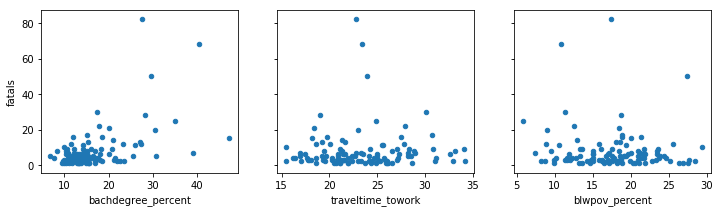

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, axs = plt.subplots(1, 3, sharey=True)


merged.plot(kind='scatter', x='bachdegree_percent', y='fatals', ax=axs[0], figsize=(12,3))
merged.plot(kind='scatter', x='traveltime_towork', y='fatals', ax=axs[1])
merged.plot(kind='scatter', x='blwpov_percent', y='fatals', ax=axs[2])


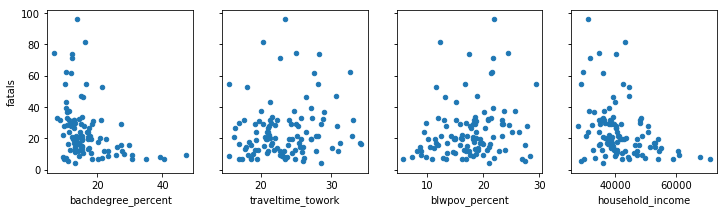

In [39]:
fig, axs = plt.subplots(1, 4, sharey=True)

merged_bypop.plot(kind='scatter', x='bachdegree_percent', y='fatals', ax=axs[0], figsize=(12, 3))
merged_bypop.plot(kind='scatter', x='traveltime_towork', y='fatals', ax=axs[1])
merged_bypop.plot(kind='scatter', x='blwpov_percent', y='fatals', ax=axs[2])
merged_bypop.plot(kind='scatter', x='household_income', y='fatals', ax=axs[3])


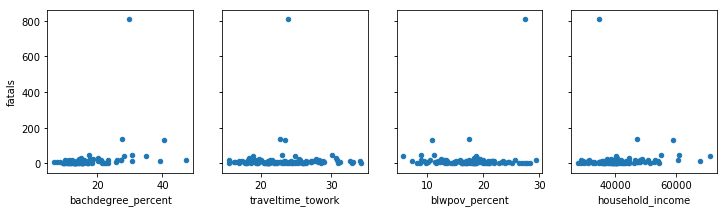

In [13]:


fig, axs = plt.subplots(1, 4, sharey=True)

merged_bysqm.plot(kind='scatter', x='bachdegree_percent', y='fatals', ax=axs[0], figsize=(12, 3))
merged_bysqm.plot(kind='scatter', x='traveltime_towork', y='fatals', ax=axs[1])
merged_bysqm.plot(kind='scatter', x='blwpov_percent', y='fatals', ax=axs[2])
merged_bysqm.plot(kind='scatter', x='household_income', y='fatals', ax=axs[3])

#clearly there's one outlier we want to move because it's messing up the scale of the y axis 

In [30]:
import scipy.stats as stats
import sklearn

from sklearn.linear_model import LinearRegression

lm = LinearRegression()

myvars = ['undr19_percent', 'ovr64_percent', 'bachdegree_percent', 'traveltime_towork', 'household_income', 
        'blwpov_percent']

X = merged_bysqm[myvars]


lm.fit(X, merged_bysqm['fatals'])

print('Estimated intercept coefficent: ', lm.intercept_)
print('Number of coefficients: ', len(lm.coef_))

#pd.DataFrame(zip(X.columns, lm.coef_), columns=['features', 'coefficients'])
pd.DataFrame(list(zip(X.columns, lm.coef_)), columns=['features', 'coefficients'])

#X.columns
#lm.coef_

Estimated intercept coefficent:  -60.2344665973
Number of coefficients:  6


,features,coefficients
0,undr19_percent,0.945167
1,ovr64_percent,-0.062548
2,bachdegree_percent,1.723591
3,traveltime_towork,0.824405
4,household_income,-0.000020
5,blwpov_percent,0.343598


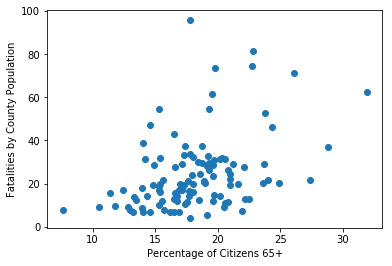

In [12]:
plt.scatter(X.ovr64_percent, merged_bypop['fatals'])

plt.xlabel("Percentage of Citizens 65+")
plt.ylabel("Fatalities by County Population")
plt.show()

In [13]:
# calculate R-squared
lm.score(X, merged_bypop['fatals'])
# really poor

# p values and conf intervals are not easily accessible through scikit-learn


0.20874051538509963

In [50]:
# this might be entirely meaningless; need to figure out how to handle these vars

categorical = ['drunk_dr', 'youngdriver', 'hitnrun', 'drowsy']

xvars = acc2015[categorical]
yvar = acc2015['fatals']

lm1 = LinearRegression() 
lm1.fit(xvars, yvar)

list(zip(categorical, lm1.coef_))



[('drunk_dr', 0.0089509438342009161),
 ('youngdriver', 0.063838788228557805),
 ('hitnrun', -0.083663879623398052),
 ('drowsy', -0.090869668951710392)]

In [43]:
import statsmodels.formula.api as smf

lm2 = smf.ols(formula='fatals ~ ovr64_percent', data=merged_bypop).fit()
lm3 = smf.ols(formula='fatals ~ traveltime_towork', data=merged_bypop).fit()

print(lm3.pvalues)
print(lm2.pvalues)

# looking at the p-values, it appears that traveltime is not a good predictor,
# while percentage of citizens 65+ does have a significant effect
print("R-squared: ", lm3.rsquared)

Intercept            0.201109
traveltime_towork    0.153065
dtype: float64
Intercept        0.246091
ovr64_percent    0.000017
dtype: float64
R-squared:  0.0189854971544


In [44]:
import statsmodels.api as sm

xx = merged_bypop[['ovr64_percent', 'traveltime_towork']]
yy = merged_bypop['fatals']
xx = sm.add_constant(xx) # add an intercept (? still a bit confused here)

aa = merged_bypop.undr19_percent
aa = sm.add_constant(aa)
#bb = merged

xx.head()

,const,ovr64_percent,traveltime_towork
0,1,17.5,23.3
1,1,23.8,18.1
2,1,16.7,21.1
3,1,20.2,22.4
4,1,18.6,19.3


In [45]:
est = sm.OLS(yy, xx).fit()

est.summary()

# this summary also tells us that traveltime is not important, while 65+ is

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 fatals   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     10.51
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           6.83e-05
Time:                        17:41:40   Log-Likelihood:                -455.34
No. Observations:                 109   AIC:                             916.7
Df Residuals:                     106   BIC:                             924.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               -14.9417     10.406     -1.436      0.154       -35.572     5.689
ovr64_percent         1.7726      0.411      4.315      0.000         0.958     2.587
traveltime_towork     0.3069      0.357      0.859      0.392        -0.401     1.015
==============================================================================
Omnibus:                       49.971   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.575
Skew:                           1.736   Prob(JB):                     9.87e-30
Kurtosis:                       7.166   Cond. No.                         203.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
est1 = sm.OLS(yy,aa)
est1 = est1.fit()
est1.summary()

# this model tells us that percentage of people <19 is not a good predictor either

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 fatals   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.534
Date:                Sat, 08 Apr 2017   Prob (F-statistic):              0.114
Time:                        16:11:34   Log-Likelihood:                -463.93
No. Observations:                 109   AIC:                             931.9
Df Residuals:                     107   BIC:                             937.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             53.2209     18.151      2.932      0.004        17.239    89.202
undr19_percent    -1.2599      0.791     -1.592      0.114        -2.829     0.309
==============================================================================
Omnibus:                       45.286   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.947
Skew:                           1.666   Prob(JB):                     1.20e-22
Kurtosis:                       6.336   Cond. No.                         253.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# what about if we use bysqm instead of bypop

xxsqm = merged_bysqm[['ovr64_percent', 'traveltime_towork']]

yysqm = merged_bysqm['fatals']

xxsqm = sm.add_constant(xxsqm)

est_sqm = sm.OLS(yysqm, xxsqm).fit()

est_sqm.summary()

#similar results to the bypop summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 fatals   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     10.88
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           5.17e-05
Time:                        17:47:49   Log-Likelihood:                -381.24
No. Observations:                 106   AIC:                             768.5
Df Residuals:                     103   BIC:                             776.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                23.0872      5.893      3.918      0.000        11.401    34.774
ovr64_percent        -1.0812      0.236     -4.589      0.000        -1.548    -0.614
traveltime_towork     0.3127      0.200      1.563      0.121        -0.084     0.710
==============================================================================
Omnibus:                       41.054   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.309
Skew:                           1.587   Prob(JB):                     8.12e-19
Kurtosis:                       5.964   Cond. No.                         204.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
x1sqm = merged_bysqm[['undr19_percent']]

est1_sqm = sm.OLS(yysqm, x1sqm).fit()
est1_sqm.summary()

# ah, interestingly, under19 is quite significant for predicting fatalities bysqm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 fatals   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     130.3
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           4.17e-20
Time:                        17:49:14   Log-Likelihood:                -390.27
No. Observations:                 106   AIC:                             782.5
Df Residuals:                     105   BIC:                             785.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
undr19_percent     0.4664      0.041     11.414      0.000         0.385     0.547
==============================================================================
Omnibus:                       53.586   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.269
Skew:                           1.926   Prob(JB):                     2.85e-32
Kurtosis:                       7.249   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
x2sqm = merged_bysqm[['bachdegree_percent']]

est2_sqm = sm.OLS(yysqm, x2sqm).fit()
est2_sqm.summary()

# education is also quite a significant predictor for fatalities bysqm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 fatals   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     194.7
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           1.16e-25
Time:                        17:53:32   Log-Likelihood:                -377.43
No. Observations:                 106   AIC:                             756.9
Df Residuals:                     105   BIC:                             759.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
bachdegree_percent     0.6717      0.048     13.954      0.000         0.576     0.767
==============================================================================
Omnibus:                       40.345   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.590
Skew:                           1.568   Prob(JB):                     3.16e-18
Kurtosis:                       5.901   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# what about education for fatalities bypop
x3pop = merged_bypop[['bachdegree_percent']]

est3_pop = sm.OLS(yy, x3pop).fit()
est3_pop.summary()

# yep, also significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 fatals   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     89.78
Date:                Sat, 08 Apr 2017   Prob (F-statistic):           7.28e-16
Time:                        17:55:22   Log-Likelihood:                -492.17
No. Observations:                 109   AIC:                             986.3
Df Residuals:                     108   BIC:                             989.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
bachdegree_percent     1.1274      0.119      9.475      0.000         0.892     1.363
==============================================================================
Omnibus:                       18.485   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.455
Skew:                           0.843   Prob(JB):                     2.97e-06
Kurtosis:                       4.661   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""